# An Empirical Comparative Analysis of Particle Swarm Optimization Algorithms for the NP-Hard Traveling Salesman Problem


## Particle Swarm Optimization Algorithm

## Hybrid Discrete Particle Swarm Optimization Algorithm

## Adaptive Particle Swarm Optimization Algorithm

## Random Sampling

## Stochastic Hill Climbing

#








| Search Algorithm         | Optimization Problem                 | Hyperparameters                                |
|--------------------------|--------------------------------------|-------------------------------------------------|
| PSO                      | Traveling Salesman Problem (TSP)     | Population size, inertia weight, acceleration coefficients, maximum velocity |
| HPSO                     | Traveling Salesman Problem (TSP)     | Population size, inertia weight, acceleration coefficients, maximum velocity, probability threshold |
| Random Sampling          | Traveling Salesman Problem (TSP)     | Number of samples                               |
| Stochastic Hill Climbing | Traveling Salesman Problem (TSP)     | Neighborhood size, maximum iterations, acceptance probability |
| Adaptive PSO             | Traveling Salesman Problem (TSP)     | Population size, inertia weight adaptation strategy, acceleration coefficients, maximum velocity |

# Base class definition and helper functions

In [57]:
import requests
import io
import gzip
import numpy as np

# URL of the .tsp file
url = "http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp/bayg29.tsp.gz"

# Send a GET request to the URL and get the response
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Read the compressed content of the response
    compressed_data = response.content

    # Decompress the gzipped data
    decompressed_data = gzip.decompress(compressed_data)

    # Convert the decompressed data to a string
    file_content = decompressed_data.decode('utf-8')

    # Split the content into lines
    lines = file_content.split('\n')

    # Find the line that starts with "EDGE_WEIGHT_SECTION"
    start_index = next(i for i, line in enumerate(lines) if line.startswith("EDGE_WEIGHT_SECTION"))

    # Find the line that starts with "DISPLAY_DATA_SECTION"
    end_index = next(i for i, line in enumerate(lines[start_index+1:], start_index+1) if line.startswith("DISPLAY_DATA_SECTION"))

    # Extract the distance matrix from the file content
    matrix_lines = lines[start_index + 1:end_index]
    matrix_data = []
    num_columns = None
    for line in matrix_lines:
        row_values = [int(value) for value in line.split()]
        if row_values:
            if num_columns is None:
                num_columns = len(row_values)
            elif len(row_values) != num_columns:
                # Skip rows with inconsistent length
                continue
            matrix_data.append(row_values)

    # Convert the matrix data to a NumPy array
    tsp_instance = np.array(matrix_data)

    print("TSP instance matrix:")
    print(tsp_instance)
else:
    print(f"Failed to download the file. Error code: {response.status_code}")

TSP instance matrix:
[[ 97 205 139  86  60 220  65 111 115 227  95  82 225 168 103 266 205 149
  120  58 257 152  52 180 136  82  34 145]]


In [65]:
import random
import math
import time
from abc import ABC, abstractmethod
import random

class StochasticHillClimber:
    def __init__(self, tsp_instance, max_iterations, max_stagnation):
        self.tsp_instance = tsp_instance
        self.max_iterations = max_iterations
        self.max_stagnation = max_stagnation

    def optimize(self):
        iteration = 0
        stagnation_counter = 0
        num_cities = len(self.tsp_instance)
        best_solution = list(range(num_cities))  # Initialize with a random solution
        random.shuffle(best_solution)  # Shuffle the initial solution
        best_fitness = PSO.calculate_fitness(best_solution, self.tsp_instance)
        convergence_data = []
        start_time = time.time()
    
        while iteration < self.max_iterations and stagnation_counter < self.max_stagnation:
            new_solution = list(best_solution)
    
            if len(new_solution) >= 2:
                i, j = random.sample(range(len(new_solution)), 2)
                new_solution[i], new_solution[j] = new_solution[j], new_solution[i]
                new_fitness = PSO.calculate_fitness(new_solution, self.tsp_instance)
    
                if new_fitness < best_fitness:
                    best_solution = new_solution
                    best_fitness = new_fitness
                    stagnation_counter = 0
                else:
                    stagnation_counter += 1
    
                convergence_data.append(best_fitness)
            else:
                # Handle the case where the length of new_solution is less than 2
                pass
    
            iteration += 1
    
        runtime = time.time() - start_time
        return best_solution, best_fitness, convergence_data, runtime

class RandomSampling:
    def __init__(self, tsp_instance, num_samples):
        self.tsp_instance = tsp_instance
        self.num_samples = num_samples

    def optimize(self):
        best_solution = None
        best_fitness = float('inf')
        runtime = 0

        for _ in range(self.num_samples):
            solution = list(range(len(self.tsp_instance)))
            random.shuffle(solution)
            fitness = PSO.calculate_fitness(solution, self.tsp_instance)

            if fitness < best_fitness:
                best_solution = solution
                best_fitness = fitness

        convergence_data = [best_fitness]
        return best_solution, best_fitness, convergence_data, runtime
class BasePSO(ABC):
    class Particle:
        def __init__(self, solution, fitness):
            self.solution = solution
            self.fitness = fitness
            self.pbest_solution = solution
            self.pbest_fitness = fitness
            self.velocity = [0] * len(solution)

    def __init__(self, tsp_instance, population_size, max_iterations, w, c1, c2):
        self.tsp_instance = tsp_instance
        self.population_size = population_size
        self.max_iterations = max_iterations
        self.w = w
        self.c1 = c1
        self.c2 = c2
        self.gbest_solution = None
        self.gbest_fitness = float('inf')
        
    @abstractmethod
    def create_particle(self):
        pass
        
    @abstractmethod
    def calculate_fitness(self, solution):
        pass
        
    def update_velocity(self, particle):
        for i in range(len(particle.velocity)):
            r1 = random.random()
            r2 = random.random()
            cognitive_velocity = self.c1 * r1 * (particle.pbest_solution[i] - particle.solution[i])
            social_velocity = self.c2 * r2 * (self.gbest_solution[i] - particle.solution[i])
            particle.velocity[i] = self.w * particle.velocity[i] + cognitive_velocity + social_velocity
            
    @abstractmethod
    def update_position(self, particle):
        pass
        
    def optimize(self):
        start_time = time.time()
        swarm = [self.create_particle() for _ in range(self.population_size)]
        
        # Initialize gbest_solution and gbest_fitness
        self.gbest_solution = swarm[0].solution
        self.gbest_fitness = swarm[0].fitness
        for particle in swarm[1:]:
            if particle.fitness < self.gbest_fitness:
                self.gbest_solution = particle.solution
                self.gbest_fitness = particle.fitness
        convergence_data = []
        for iteration in range(self.max_iterations):
            for particle in swarm:
                self.update_velocity(particle)
                self.update_position(particle)
                
                # Update gbest_solution and gbest_fitness
                if particle.fitness < self.gbest_fitness:
                    self.gbest_solution = particle.solution
                    self.gbest_fitness = particle.fitness
            convergence_data.append(self.gbest_fitness)
        end_time = time.time()
        runtime = end_time - start_time          
        return self.gbest_solution, self.gbest_fitness, convergence_data, runtime

class PSO(BasePSO):
    def create_particle(self):
        solution = random.sample(range(1, len(self.tsp_instance) + 1), len(self.tsp_instance))
        fitness = self.calculate_fitness(solution ,self.tsp_instance)
        return BasePSO.Particle(solution, fitness)
        
    @staticmethod
    def calculate_fitness(solution, tsp_instance):
        total_distance = 0
        for i in range(len(solution)):
            city1 = solution[i] - 1  # Adjust the indexing to start from 0
            city2 = solution[(i + 1) % len(solution)] - 1  # Adjust the indexing to start from 0
            total_distance += tsp_instance[city1][city2]
        return total_distance
        
    def update_position(self, particle):
        new_solution = particle.solution[:]
        for i in range(len(new_solution)):
            if random.random() < math.tanh(abs(particle.velocity[i])):
                j = random.randint(0, len(new_solution) - 1)
                new_solution[i], new_solution[j] = new_solution[j], new_solution[i]
        new_fitness = self.calculate_fitness(new_solution, self.tsp_instance)
        if new_fitness < particle.fitness:
            particle.solution = new_solution
            particle.fitness = new_fitness
            if new_fitness < particle.pbest_fitness:
                particle.pbest_solution = new_solution
                particle.pbest_fitness = new_fitness

class APSO(PSO):
    def __init__(self, tsp_instance, population_size, max_iterations, w_min, w_max, c1, c2):
        super().__init__(tsp_instance, population_size, max_iterations, None, c1, c2)
        self.w_min = w_min
        self.w_max = w_max
        
    def update_velocity(self, particle, iteration):
        w = self.w_max - (self.w_max - self.w_min) * (iteration / self.max_iterations)
        for i in range(len(particle.velocity)):
            r1 = random.random()
            r2 = random.random()
            cognitive_velocity = self.c1 * r1 * (particle.pbest_solution[i] - particle.solution[i])
            social_velocity = self.c2 * r2 * (self.gbest_solution[i] - particle.solution[i])
            particle.velocity[i] = w * particle.velocity[i] + cognitive_velocity + social_velocity
            
    def optimize(self):
        start_time = time.time()
        swarm = [self.create_particle() for _ in range(self.population_size)]
        
        # Initialize gbest_solution and gbest_fitness
        self.gbest_solution = swarm[0].solution
        self.gbest_fitness = swarm[0].fitness
        for particle in swarm[1:]:
            if particle.fitness < self.gbest_fitness:
                self.gbest_solution = particle.solution
                self.gbest_fitness = particle.fitness
        convergence_data = []
        for iteration in range(self.max_iterations):
            for particle in swarm:
                self.update_velocity(particle, iteration)
                self.update_position(particle)
                
                # Update gbest_solution and gbest_fitness
                if particle.fitness < self.gbest_fitness:
                    self.gbest_solution = particle.solution
                    self.gbest_fitness = particle.fitness
            convergence_data.append(self.gbest_fitness)
        end_time = time.time()
        runtime = end_time - start_time       
        return self.gbest_solution, self.gbest_fitness, convergence_data, runtime

class DiscretePSO(PSO):
    def create_particle(self):
        solution = random.sample(range(1, len(self.tsp_instance) + 1), len(self.tsp_instance))
        fitness = self.calculate_fitness(solution,self.tsp_instance)
        return BasePSO.Particle(solution, fitness)
        
        
    def update_velocity(self, particle):
        for i in range(len(particle.velocity)):
            r1 = random.random()
            r2 = random.random()
            cognitive_velocity = self.c1 * r1 * (particle.pbest_solution[i] - particle.solution[i])
            social_velocity = self.c2 * r2 * (self.gbest_solution[i] - particle.solution[i])
            particle.velocity[i] = math.ceil(self.w * particle.velocity[i] + cognitive_velocity + social_velocity)
            
    def update_position(self, particle):
        new_solution = particle.solution[:]
        for i in range(len(new_solution)):
            if random.random() < 1 / (1 + math.exp(-abs(particle.velocity[i]))):
                j = random.randint(0, len(new_solution) - 1)
                new_solution[i], new_solution[j] = new_solution[j], new_solution[i]
        new_fitness = self.calculate_fitness(new_solution, self.tsp_instance)
        if new_fitness < particle.fitness:
            particle.solution = new_solution
            particle.fitness = new_fitness
            if new_fitness < particle.pbest_fitness:
                particle.pbest_solution = new_solution
                particle.pbest_fitness = new_fitness

# Usage example
# tsp_instance = [
#     [0, 10, 15, 20],
#     [10, 0, 35, 25],
#     [15, 35, 0, 30],
#     [20, 25, 30, 0]
# ]

pso = PSO(tsp_instance, population_size=50, max_iterations=100, w=0.8, c1=2, c2=2)
best_solution, best_fitness,convergence_data, runtime = pso.optimize()
print("PSO Best solution:", best_solution)
print("PSO Best fitness:", best_fitness)

apso = APSO(tsp_instance, population_size=50, max_iterations=100, w_min=0.4, w_max=0.9, c1=2, c2=2)
best_solution, best_fitness, convergence_data, runtime = apso.optimize()
print("APSO Best solution:", best_solution)
print("APSO Best fitness:", best_fitness)

HPSO = DiscretePSO(tsp_instance, population_size=50, max_iterations=100, w=0.8, c1=2, c2=2)
best_solution, best_fitness, convergence_data, runtime = HPSO.optimize()
print("HPSO Best solution:", best_solution)
print("HPSO Best fitness:", best_fitness)

PSO Best solution: [1]
PSO Best fitness: 97
APSO Best solution: [1]
APSO Best fitness: 97
HPSO Best solution: [1]
HPSO Best fitness: 97


In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
class PrettyPlotting:
    def __init__(self):
        #plt.style.use('seaborn')
        sns.set(style='whitegrid', palette='muted', font_scale=1.2)
        
    def convergence_plot(self, data, algorithms, problem_instance):
        plt.figure(figsize=(8, 6))
        for algorithm in algorithms:
            for run_data in data[algorithm]:
                iterations = range(1, len(run_data['convergence_data']) + 1)
                best_tour_lengths = run_data['convergence_data']
                plt.plot(iterations, best_tour_lengths, label=f"{algorithm} - Run {data[algorithm].index(run_data) + 1}")
        plt.xlabel('Number of Iterations')
        plt.ylabel('Best Tour Length')
        plt.title(f'Convergence Plot - Problem Instance: {problem_instance}')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
    def bar_chart_average_tour_length(self, data, algorithms, problem_instances):
        plt.figure(figsize=(10, 6))
        x = range(len(problem_instances))
        width = 0.8 / len(algorithms)
        for i, algorithm in enumerate(algorithms):
            avg_best_tour_lengths = []
            for instance in problem_instances:
                best_tour_lengths = [run_data['best_fitness'] for run_data in data[algorithm]]
                avg_best_tour_length = sum(best_tour_lengths) / len(best_tour_lengths)
                avg_best_tour_lengths.append(avg_best_tour_length)
            plt.bar([xi + i * width for xi in x], avg_best_tour_lengths, width=width, label=algorithm)
        plt.xticks([xi + (len(algorithms) - 1) * width / 2 for xi in x], problem_instances)
        plt.xlabel('Problem Instances')
        plt.ylabel('Average Best Tour Length')
        plt.title('Average Best Tour Length Comparison')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
    def bar_chart_average_runtime(self, data, algorithms, problem_instances):
        plt.figure(figsize=(10, 6))
        x = range(len(problem_instances))
        width = 0.8 / len(algorithms)
        for i, algorithm in enumerate(algorithms):
            avg_runtimes = []
            for instance in problem_instances:
                runtimes = [run_data['runtime'] for run_data in data[algorithm]]
                avg_runtime = sum(runtimes) / len(runtimes)
                avg_runtimes.append(avg_runtime)
            plt.bar([xi + i * width for xi in x], avg_runtimes, width=width, label=algorithm)
        plt.xticks([xi + (len(algorithms) - 1) * width / 2 for xi in x], problem_instances)
        plt.xlabel('Problem Instances')
        plt.ylabel('Average Runtime (s)')
        plt.title('Average Runtime Comparison')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
    def box_plot_tour_lengths(self, data, algorithms):
        plt.figure(figsize=(10, 6))
        tour_lengths = []
        for algorithm in algorithms:
            algorithm_data = data[algorithm]
            if algorithm == 'HPSO':
                tour_lengths.append([run['best_fitness'] for run in algorithm_data])
            else:
                # Assuming the same data structure for other algorithms
                tour_lengths.append([run['best_fitness'] for run in algorithm_data])
        plt.boxplot(tour_lengths, labels=algorithms)
        plt.ylabel('Best Tour Length')
        plt.title('Distribution of Best Tour Lengths')
    
    def performance_heatmap(self, data, algorithms, instances):
        # Create a dictionary to store performance ranks
        performance_ranks = {}

        # Iterate over instances
        for instance in instances:
            # Sort algorithms by best tour length for this instance
            sorted_algos = sorted(algorithms, key=lambda algo: min(data[algo][instance]['best_fitness']))

            # Assign ranks based on the sorted order
            for rank, algo in enumerate(sorted_algos, start=1):
                performance_ranks.setdefault(algo, {})[instance] = rank

        # Create a DataFrame from the performance_ranks dictionary
        df = pd.DataFrame.from_dict(performance_ranks, orient='index')

        # Create the heatmap
        plt.figure(figsize=(10, 6))
        sns.heatmap(df, annot=True, cmap='YlGnBu')
        plt.xlabel('Problem Instances')
        plt.ylabel('Algorithms')
        plt.title('Performance Comparison Matrix')

    def tour_length_vs_runtime(self, data, algorithms, instances):
        plt.figure(figsize=(10, 6))

        # Iterate over algorithms
        for algo in algorithms:
            # Iterate over instances
            for instance in instances:
                # Extract tour lengths and runtimes for this algorithm and instance
                tour_lengths = data[algo][instance]['best_fitness']
                runtimes = data[algo][instance]['runtime']

                # Plot a point for each run
                plt.scatter(runtimes, tour_lengths, label=f'{algo} ({instance} cities)', alpha=0.5)

        plt.xlabel('Runtime')
        plt.ylabel('Best Tour Length')
        plt.title('Tour Length vs. Runtime')
        plt.legend()

       
       
    

# Aim: Performance comparison of search algorithms { PSO , Binary PSO , Adaptive PSO , Random Sampling , Stochastic Hill Climbing }

# Experiment Design
Objective: Compare the performance of PSO, HPSO, Random Sampling, Stochastic Hill Climbing, and Adaptive PSO on the Traveling Salesman Problem (TSP).
    Problem instances: Select a set of benchmark TSP instances with varying sizes (e.g., 50, 100, 200 cities).
    Performance metrics: Tour length (objective value), convergence speed, and runtime.
    Parameter settings: Use recommended or commonly used hyperparameter values for each algorithm.
    Procedure: Run each algorithm on each problem instance for a fixed number of iterations or until convergence. Record the performance metrics.
    Analysis: Compare the algorithms based on their average performance across problem instances. Identify the strengths and weaknesses of each algorithm.

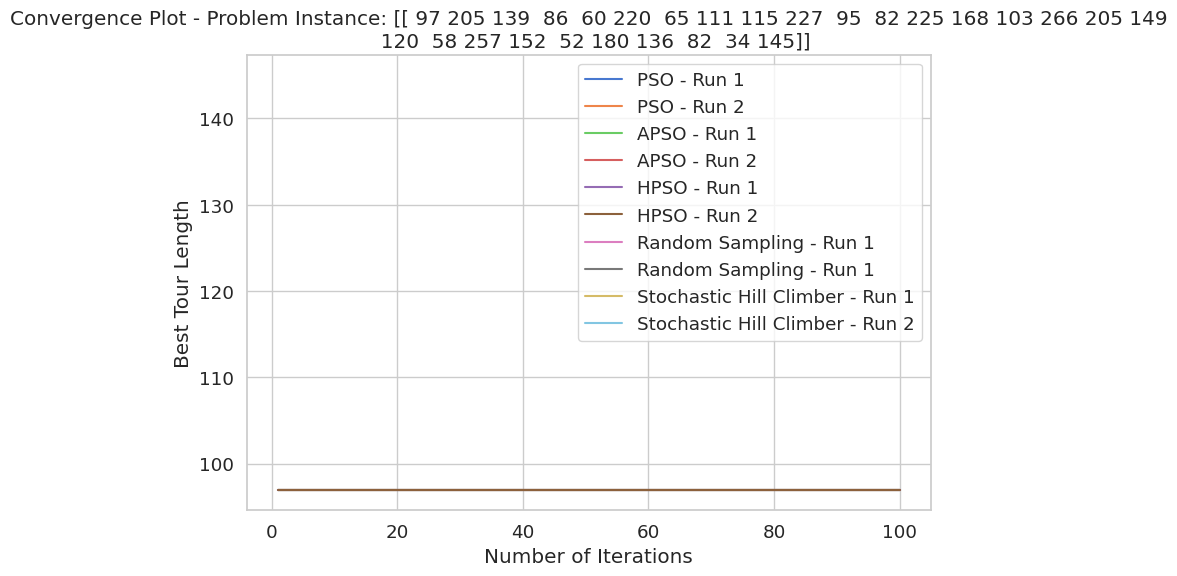

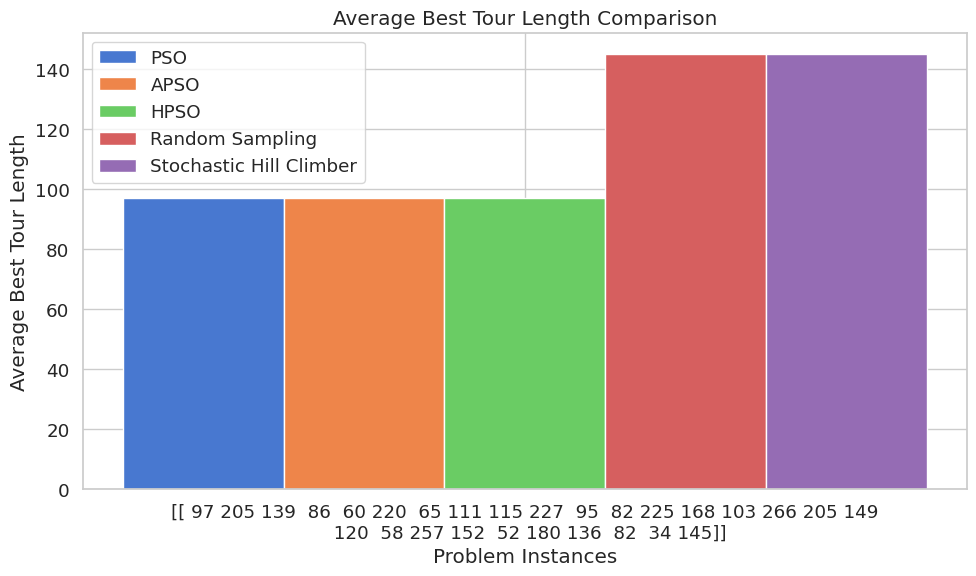

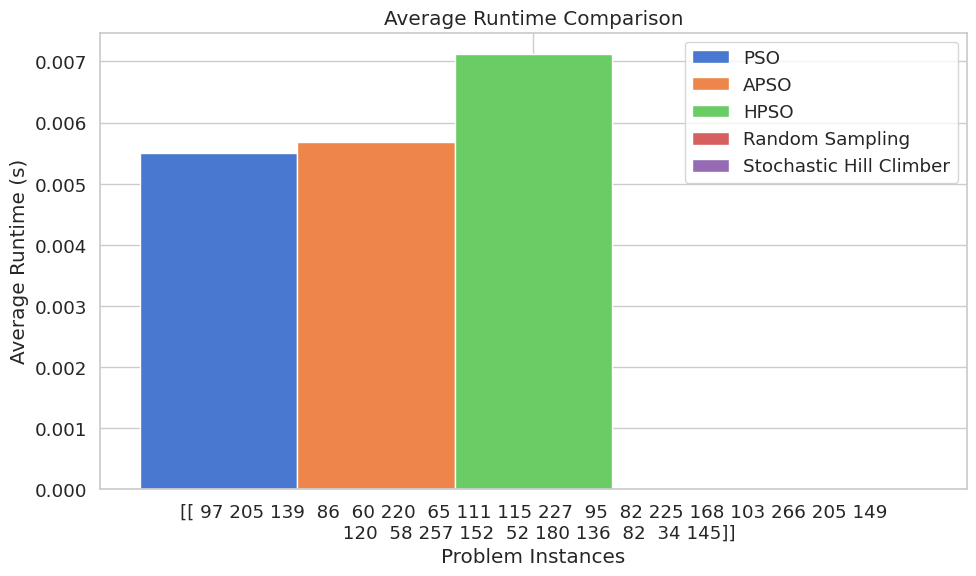

TypeError: only integer scalar arrays can be converted to a scalar index

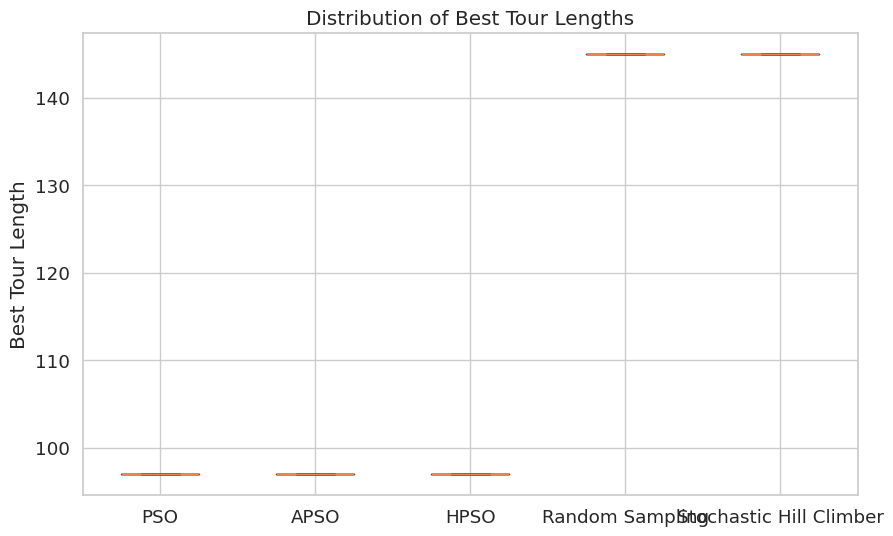

In [66]:


# Create an instance of the PrettyPlotting class
plotter = PrettyPlotting()

# Run the optimization algorithms and collect data
pso_data = []
apso_data = []
hpso_data = []
random_sampling_data = []
stochastic_hill_climber_data = []
num_runs = 2
for _ in range(num_runs):
    # Run PSO and collect data
    pso = PSO(tsp_instance, population_size=50, max_iterations=100, w=0.8, c1=2, c2=2)
    best_solution, best_fitness, convergence_data, runtime = pso.optimize()
    pso_data.append({'best_solution': best_solution, 'best_fitness': best_fitness, 'convergence_data': convergence_data, 'runtime': runtime})
    
    # Run APSO and collect data
    apso = APSO(tsp_instance, population_size=50, max_iterations=100, w_min=0.4, w_max=0.9, c1=2, c2=2)
    best_solution, best_fitness, convergence_data, runtime = apso.optimize()
    apso_data.append({'best_solution': best_solution, 'best_fitness': best_fitness, 'convergence_data': convergence_data, 'runtime': runtime})
    
    # Run HPSO and collect data
    hpso = DiscretePSO(tsp_instance, population_size=50, max_iterations=100, w=0.8, c1=2, c2=2)
    best_solution, best_fitness, convergence_data, runtime = hpso.optimize()
    hpso_data.append({'best_solution': best_solution, 'best_fitness': best_fitness, 'convergence_data': convergence_data, 'runtime': runtime})
    
    # Run Random Sampling and collect data
    random_sampling = RandomSampling(tsp_instance, num_samples=10)
    best_solution, best_fitness, convergence_data, runtime = random_sampling.optimize()
    random_sampling_data.append({'best_solution': best_solution, 'best_fitness': best_fitness, 'convergence_data': convergence_data, 'runtime': runtime})

    # Run Stochastic Hill Climber and collect data
    stochastic_hill_climber = StochasticHillClimber(tsp_instance, max_iterations=10, max_stagnation=100)
    best_solution, best_fitness, convergence_data, runtime = stochastic_hill_climber.optimize()
    stochastic_hill_climber_data.append({'best_solution': best_solution, 'best_fitness': best_fitness, 'convergence_data': convergence_data, 'runtime': runtime})

# Prepare data for plotting
algorithms = ['PSO', 'APSO', 'HPSO', 'Random Sampling', 'Stochastic Hill Climber']
data = {
    'PSO': pso_data,
    'APSO': apso_data,
    'HPSO': hpso_data,
    'Random Sampling': random_sampling_data,
    'Stochastic Hill Climber': stochastic_hill_climber_data
}


# Generate plots
plotter.convergence_plot(data, algorithms, tsp_instance)
plotter.bar_chart_average_tour_length(data, algorithms, [tsp_instance])
plotter.bar_chart_average_runtime(data, algorithms, [tsp_instance])
plotter.box_plot_tour_lengths(data, algorithms)
plotter.performance_heatmap(data, algorithms,[tsp_instance])
plotter.tour_length_vs_runtime(data, algorithms,[tsp_instance])



# Analysis


    Convergence Plot:
        x-axis: Number of iterations
        y-axis: Best tour length (objective value)
        Plot the convergence curve for each algorithm on each problem instance.
        This plot will show how quickly each algorithm converges to a good solution and how the solution quality improves over iterations.
    Bar Chart - Average Best Tour Length:
        x-axis: Problem instances (50, 100, 200 cities)
        y-axis: Average best tour length
        Create a grouped bar chart with a bar for each algorithm on each problem instance.
        This plot will compare the final solution quality achieved by each algorithm on different problem sizes.
    Bar Chart - Average Runtime:
        x-axis: Problem instances (50, 100, 200 cities)
        y-axis: Average runtime (in seconds or appropriate time unit)
        Create a grouped bar chart with a bar for each algorithm on each problem instance.
        This plot will compare the computational efficiency of each algorithm on different problem sizes.
    Box Plot - Distribution of Best Tour Lengths:
        x-axis: Algorithms (PSO, HPSO, Random Sampling, Stochastic Hill Climbing, Adaptive PSO)
        y-axis: Best tour length
        Create a box plot for each algorithm, showing the distribution of best tour lengths across all problem instances.
        This plot will provide insights into the consistency and robustness of each algorithm.
    Heatmap - Performance Comparison Matrix:
        x-axis: Algorithms (PSO, HPSO, Random Sampling, Stochastic Hill Climbing, Adaptive PSO)
        y-axis: Problem instances (50, 100, 200 cities)
        Each cell represents the relative performance of an algorithm on a specific problem instance (e.g., rank based on best tour length).
        Use color coding to visualize the performance patterns.
        This plot will provide an overall comparison of algorithm performance across different problem instances.
    Scatter Plot - Tour Length vs. Runtime:
        x-axis: Runtime
        y-axis: Best tour length
        Create a scatter plot with a point for each algorithm on each problem instance.
        This plot will show the trade-off between solution quality and computational efficiency for each algorithm.


# Aim: Sensitivity analysis of hyperparameters


# Experiment Design
Objective: Investigate the impact of hyperparameter settings on the performance of PSO and HPSO.
    Problem instance: Select a representative TSP instance of moderate size (e.g., 100 cities).
    Hyperparameters: Vary the population size, inertia weight, acceleration coefficients, and maximum velocity for PSO. Additionally, vary the probability threshold for HPSO.
    Performance metrics: Tour length (objective value) and convergence speed.
    Procedure: Run PSO and HPSO with different hyperparameter settings on the selected problem instance. Record the performance metrics for each setting.
    Analysis: Identify the hyperparameter settings that lead to the best performance for PSO and HPSO. Discuss the sensitivity of each algorithm to its hyperparameters.


# Analysis


    Line Plot - Impact of Population Size:
        x-axis: Population size
        y-axis: Best tour length (objective value)
        Create separate lines for PSO and HPSO.
        This plot will show how the performance of each algorithm varies with different population sizes.
    Line Plot - Impact of Inertia Weight (PSO):
        x-axis: Inertia weight
        y-axis: Best tour length (objective value)
        Create a line plot for PSO.
        This plot will demonstrate the effect of inertia weight on the performance of PSO.
    Line Plot - Impact of Acceleration Coefficients (PSO):
        x-axis: Acceleration coefficients (c1 and c2)
        y-axis: Best tour length (objective value)
        Create separate lines for different combinations of c1 and c2 values.
        This plot will show how the balance between cognitive and social components affects PSO's performance.
    Line Plot - Impact of Maximum Velocity (PSO):
        x-axis: Maximum velocity
        y-axis: Best tour length (objective value)
        Create a line plot for PSO.
        This plot will illustrate the effect of maximum velocity on the performance of PSO.
    Line Plot - Impact of Probability Threshold (HPSO):
        x-axis: Probability threshold
        y-axis: Best tour length (objective value)
        Create a line plot for HPSO.
        This plot will show how the probability threshold influences the performance of HPSO.
    Convergence Plot - Best Hyperparameter Settings:
        x-axis: Number of iterations
        y-axis: Best tour length (objective value)
        Create separate convergence curves for PSO and HPSO using their best hyperparameter settings.
        This plot will compare the convergence speed and solution quality of PSO and HPSO with optimized hyperparameters.
    Heatmap - Hyperparameter Sensitivity:
        x-axis: Hyperparameters (population size, inertia weight, acceleration coefficients, maximum velocity, probability threshold)
        y-axis: Algorithms (PSO, HPSO)
        Each cell represents the relative impact of a hyperparameter on the algorithm's performance (e.g., percentage change in best tour length).
        Use color coding to visualize the sensitivity patterns.
        This plot will provide an overall comparison of the sensitivity of PSO and HPSO to their respective hyperparameters.


# Aim: Scalability analysis

# Experiment Design
Objective: Evaluate the scalability of PSO, HPSO, and Adaptive PSO with increasing problem size.
    Problem instances: Select a range of TSP instances with increasing sizes (e.g., 50, 100, 200, 500, 1000 cities).
    Performance metrics: Tour length (objective value) and runtime.
    Procedure: Run PSO, HPSO, and Adaptive PSO on each problem instance. Record the performance metrics for each algorithm and instance.
    Analysis: Investigate how the performance of each algorithm scales with increasing problem size. Identify any limitations or advantages of each algorithm in terms of scalability.

# Analysis


    Line Plot - Tour Length vs. Problem Size:
        x-axis: Problem size (number of cities)
        y-axis: Best tour length (objective value)
        Create separate lines for PSO, HPSO, and Adaptive PSO.
        This plot will show how the solution quality of each algorithm varies with increasing problem size.
    Line Plot - Runtime vs. Problem Size:
        x-axis: Problem size (number of cities)
        y-axis: Runtime (in seconds or appropriate time unit)
        Create separate lines for PSO, HPSO, and Adaptive PSO.
        This plot will illustrate how the computational efficiency of each algorithm scales with increasing problem size.
    Bar Chart - Relative Performance by Problem Size:
        x-axis: Problem size (number of cities)
        y-axis: Relative performance (ratio of best tour length to optimal or best-known solution)
        Create grouped bars for PSO, HPSO, and Adaptive PSO at each problem size.
        This plot will compare the relative performance of the algorithms across different problem sizes.
    Scatter Plot - Tour Length vs. Runtime:
        x-axis: Runtime (in seconds or appropriate time unit)
        y-axis: Best tour length (objective value)
        Create separate scatter plots for PSO, HPSO, and Adaptive PSO.
        Each point represents a problem instance.
        This plot will show the trade-off between solution quality and computational efficiency for each algorithm as the problem size increases.
    Heatmap - Algorithm Performance by Problem Size:
        x-axis: Problem size (number of cities)
        y-axis: Algorithms (PSO, HPSO, Adaptive PSO)
        Each cell represents the relative performance of an algorithm on a specific problem size (e.g., rank based on best tour length).
        Use color coding to visualize the performance patterns.
        This plot will provide an overall comparison of algorithm performance across different problem sizes.
    Convergence Plot - Scalability Comparison:
        x-axis: Number of iterations
        y-axis: Best tour length (objective value)
        Create separate convergence curves for PSO, HPSO, and Adaptive PSO on selected problem sizes (e.g., 50, 200, 1000 cities).
        This plot will compare the convergence behavior of the algorithms on different problem scales.

